In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import cv2
import copy
from PIL import Image
from moviepy.editor import *
import time

In [3]:
pip install face_recognition

     |████████████████████████████████| 100.2MB 55kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=75e38f5c7a024c99012e4db460370500efd74e0914fcb512a88c66df3a4d8b9e
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [3]:
import face_recognition

# Video

* Videopath: the path of input video to be processed.

* Framedir: the dir path of frames extracted from the video. (Clipped out the desired part)

* Detectdir: not necessary, it's only used for method 1 to store the results of face detector.

* Modeloutputdir: the dir path of output frames from the model.

* Resultpath: target video path.

* Videofps: the original fps of input video.

* Ourfps: the desired fps of output video.

In [ ]:
WORKSPACE = '/content/drive/MyDrive/'
videopath = '/content/drive/MyDrive/myvideo.mp4'
framedir = '/content/drive/MyDrive/myoutput/'
# clippeddir = '/content/drive/MyDrive/myoutput0/'
detectdir = '/content/drive/MyDrive/myoutput1/'
modeloutputdir = '/content/drive/MyDrive/myoutput2/'
resultpath = '/content/drive/MyDrive/mynewvideo_3.mp4'
videofps = 30
ourfps = 30

## Video Processing Part

In [ ]:
def video2frames(videopath, outputdir, videofps, ourfps, h0, h1, w0, w1):
  videoCapture = cv2.VideoCapture(videopath)
  success, frame = videoCapture.read()

  i, j = 0, 0
  while success:
    if i % (videofps // ourfps) == 0:
      j += 1
      newpath = outputdir + str(j) + '.jpg'
      image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      image = image[h0:h1, w0:w1]
      image = Image.fromarray(image)
      image.save(newpath)
      # cv2.imwrite(newpath, frame)
    success, frame = videoCapture.read()
    i += 1

In [ ]:
def frames2video(inputdir, targetpath, ourfps):
  files = os.listdir(inputdir)
  filelist = []
  for f in files:
    filelist.append(os.path.join(inputdir, f))
  clip = ImageSequenceClip(filelist, fps=ourfps)
  clip.write_videofile(targetpath)

In [ ]:
def facedetector(inputdir, outputdir, status=0):
  files = os.listdir(inputdir)
  nofaces = []
  for f in files:
    impath = os.path.join(inputdir, f)
    image = face_recognition.load_image_file(impath)
    temp = np.array(Image.open(impath))
    face_locations = face_recognition.face_locations(image)
    if len(face_locations):
      if status > 0:
        top, right, bottom, left = face_locations[0]
        height = bottom - top
        length = right - left
        _ = cv2.rectangle(temp, (left, top), (right, bottom), (0, 255, 0), 2)
    else: nofaces.append(os.path.join(outputdir, f))
    temp = Image.fromarray(temp)
    temp.save(os.path.join(outputdir, f))
  return nofaces

In [ ]:
def modelPred(inputdir, outputdir, model, nofaces, dotsize, xinch, yinch):
  files = os.listdir(inputdir)
  for f in files:
    address = os.path.join(inputdir, f)
    fraw = Image.open(address)
    plt.figure(figsize=(xinch*1.94, yinch*1.94))
    plt.axis('off')
    plt.imshow(fraw)
    if address not in nofaces:
      rawh, raww = fraw.size[0:2]
      ratioh, ratiow = 224.0 / rawh, 224.0 / raww
      f1 = fraw.resize((224,224))
      f1 = np.array([np.array(f1)])
      pre = model.predict(f1/255)[0]
      raw_pre = copy.deepcopy(pre)
      raw_pre[0::2] /= ratioh
      raw_pre[1::2] /= ratiow
      raw_pre = raw_pre.astype(np.int)
      plt.plot(raw_pre[0::2], raw_pre[1::2], '.r', markersize=dotsize)
    plt.savefig(os.path.join(outputdir, f), bbox_inches='tight', pad_inches=0.0)
    plt.close()

Now, for method 2, just combine the face detector and model prediction together:

In [ ]:
def facePointsDetect(inputdir, outputdir, model, status, dotsize, xinch, yinch):
  files = os.listdir(inputdir)
  for f in files:
    impath = os.path.join(inputdir, f)
    fraw = np.array(Image.open(impath))
    image = face_recognition.load_image_file(impath)
    face_locations = face_recognition.face_locations(image)
    plt.figure(figsize=(xinch*1.94, yinch*1.94))
    plt.axis('off')
    if len(face_locations):   # the face detector finds faces
      # first, crop out the face part and feed in model
      top, right, bottom, left = face_locations[0]
      f1 = fraw[top:bottom, left:right]
      rawh, raww = f1.shape[0:2]
      ratioh, ratiow = 224.0 / rawh, 224.0 / raww
      f1 = Image.fromarray(f1)
      f1 = f1.resize((224,224))
      f1 = np.array([np.array(f1)])
      pre = model.predict(f1/255.0)
      f1 = f1[0]
      pre = pre[0]
      pre[0::2] /= ratiow
      pre[1::2] /= ratioh
      pre = pre.astype(np.int)
      pre[0::2] += left
      pre[1::2] += top
      plt.plot(pre[0::2], pre[1::2], '.r', markersize=dotsize)
      
      if status > 0:
        height = bottom - top
        length = right - left
        _ = cv2.rectangle(fraw, (left, top), (right, bottom), (0, 255, 0), 2)
    fraw = Image.fromarray(fraw)
    plt.imshow(fraw)
    plt.savefig(os.path.join(outputdir, f), bbox_inches='tight', pad_inches=0.0)
    plt.close()

* Method 1: no face detector, just *MobileNet* model

  TO RUN:

  video2frames -> facedetector -> modelPred -> frames2video



* Method 2: use the result of a face detector, feed into a *MobileNet* model

  TO RUN:

  video2frames -> facePointsDetect -> frames2video




In [ ]:
### video -> frames -> clipped frames   (for both method 1 and method 2)
print(' - video -> frames')
video2frames(videopath, framedir, videofps=videofps, ourfps=ourfps, h0=100, h1=500, w0=680, w1=1230)  # myvideo
# video2frames(videopath, framedir, videofps=videofps, ourfps=ourfps, h0=50, h1=500, w0=150, w1=750)  # myvideo1
# video2frames(videopath, framedir, videofps=videofps, ourfps=ourfps, h0=50, h1=250, w0=400, w1=600)  # myvideo30
# video2frames(videopath, framedir, videofps=videofps, ourfps=ourfps, h0=50, h1=350, w0=100, w1=750)  # myvideo22
# video2frames(videopath, framedir, videofps=videofps, ourfps=ourfps, h0=0, h1=1080, w0=0, w1=1920)   # myvideo44
# video2frames(videopath, framedir, videofps=videofps, ourfps=ourfps, h0=50, h1=850, w0=450, w1=1450)   # myvideo51

 - video -> frames


In [ ]:
### face detection  (for method 1)
print(' - face detection')
nofaces = facedetector(framedir, detectdir, status=0)
### insert model here  (for method 1)
print(' - model')
modelPred(detectdir, modeloutputdir, model, nofaces, dotsize=12, xinch=5.5, yinch=4)   # xinch: width, yinch: height, dpi:100

In [ ]:
### face detect + model prediction (for method 2)
print(' - face detection and model prediction')
facePointsDetect(framedir, modeloutputdir, model, status=1, dotsize=12, xinch=5.5, yinch=4)   # xinch: width, yinch: height, dpi:100

 - face detection and model prediction


In [ ]:
### output images -> video  (for both method 1 and method 2)
print(' - video')
frames2video(modeloutputdir, resultpath, ourfps=ourfps)

 - video
[MoviePy] >>>> Building video /content/drive/MyDrive/mynewvideo_3.mp4
[MoviePy] Writing video /content/drive/MyDrive/mynewvideo_3.mp4


100%|██████████| 551/551 [00:07<00:00, 69.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/mynewvideo_3.mp4 



# Model

## Copy Data from GoogleDrive and Data Processing

In [5]:
!cp /content/drive/MyDrive/facedata.zip ./

In [ ]:
!unzip facedata.zip

In [4]:
# 2nd method: first do face detection then feed into model
f = open('/content/facedata/trainImageList.txt', 'rt')
DATAPATH = '/content/facedata/'
line = f.readline()
# i = 0
label = []
data = []
# while i < 50:
while len(line):
  # i += 1
  items = line.split(' ')
  address = os.path.join(DATAPATH, items[0].replace('\\','/'))
  l, r, t, b = list(map(int, items[1: 5]))
  im = Image.open(address)
  im2 = np.array(im)[t:b,l:r]
  # rawh, raww = im.size[0:2]
  rawh, raww = im2.shape[0:2]
  ratioh, ratiow = 224.0 / rawh, 224.0 / raww

  tags = np.array(list(map(float, items[5: 15])))
  tags[0::2] -= t
  tags[1::2] -= l
  tags[0::2] *= ratioh
  tags[1::2] *= ratiow
  label.append(tags)

  im = Image.fromarray(im2)
  im = im.resize((224,224))
  data.append(np.array(im))
  line = f.readline()
data = np.array(data)
label = np.array(label)
data = data / 255.0
traindata, valdata = data[0:len(data)*8//10], data[len(data)*8//10:]
trainlabel, vallabel = label[0:len(label)*8//10], label[len(label)*8//10:]
data = None
label = None

In [7]:
# 1st method: without face detection

f = open('/content/facedata/trainImageList.txt', 'rt')
DATAPATH = '/content/facedata/'
line = f.readline()
# i = 0
label = []
data = []
# while i < 50:
while len(line):
  # i += 1
  items = line.split(' ')
  address = os.path.join(DATAPATH, items[0].replace('\\','/'))
  l, r, t, b = list(map(int, items[1: 5]))
  im = Image.open(address)
  rawh, raww = im.size[0:2]
  ratioh, ratiow = 224.0 / rawh, 224.0 / raww

  tags = np.array(list(map(float, items[5: 15])))
  tags[0::2] *= ratioh
  tags[1::2] *= ratiow
  label.append(tags)

  im = im.resize((224,224))
  data.append(np.array(im))
  line = f.readline()
data = np.array(data)
label = np.array(label)
data = data / 255.0
traindata, valdata = data[0:len(data)*8//10], data[len(data)*8//10:]
trainlabel, vallabel = label[0:len(label)*8//10], label[len(label)*8//10:]
data = None
label = None


In [8]:
traindata.shape

(8000, 224, 224, 3)

## Model Training Part

In [5]:
import tensorflow as tf
from keras.utils import to_categorical
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Conv2DTranspose, Conv2D
from keras.layers.core import Dense, Activation, Flatten

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, Input, Reshape, Flatten, Embedding, Dropout

from keras.applications.mobilenet import MobileNet
# from keras.applications.mobilenet_v2 import MobileNetV2
from keras.optimizers import SGD, Adam, Adagrad, RMSprop
from keras.models import load_model

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

In [6]:
input_tensor = Input(shape=(224, 224, 3))
model = MobileNet(input_tensor = input_tensor, include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x = model.output
x = ZeroPadding2D()(x)
x = AveragePooling2D((3,3))(x)
x = Flatten()(x)

# x = Dense(128, activation=tf.keras.layers.LeakyReLU())(x)
x = Dropout(0.3)(x)
# predictions = Dense(10, activation=tf.keras.layers.LeakyReLU())(x)
predictions = Dense(10, activation=None)(x)

model = Model(inputs=input_tensor, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0005),loss='mse',metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])
# model.compile(optimizer=Adam(lr=0.0005),loss='mse',metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

In [7]:
history = model.fit(traindata, trainlabel, batch_size=32,
				  epochs=35, validation_data=(valdata, vallabel),
				  shuffle=True)

Epoch 1/35
250/250 [==============================] - 58s 157ms/step - loss: 3320.2136 - mean_absolute_error: 37.1539 - root_mean_squared_error: 53.0153 - val_loss: 469.1148 - val_mean_absolute_error: 16.7022 - val_root_mean_squared_error: 21.6591
Epoch 2/35
250/250 [==============================] - 38s 151ms/step - loss: 153.5050 - mean_absolute_error: 9.3616 - root_mean_squared_error: 12.3786 - val_loss: 255.7758 - val_mean_absolute_error: 11.5415 - val_root_mean_squared_error: 15.9930
Epoch 3/35
250/250 [==============================] - 38s 151ms/step - loss: 101.4918 - mean_absolute_error: 7.4334 - root_mean_squared_error: 10.0558 - val_loss: 273.5873 - val_mean_absolute_error: 12.0045 - val_root_mean_squared_error: 16.5405
Epoch 4/35
250/250 [==============================] - 38s 151ms/step - loss: 75.9632 - mean_absolute_error: 6.5225 - root_mean_squared_error: 8.7129 - val_loss: 306.6189 - val_mean_absolute_error: 12.9557 - val_root_mean_squared_error: 17.5105
Epoch 5/35
250/2

In [ ]:
# model.save('/content/drive/MyDrive/faceDetect-5-4.h5')

In [8]:
model = load_model('/content/drive/MyDrive/faceDetect-5-4.h5')

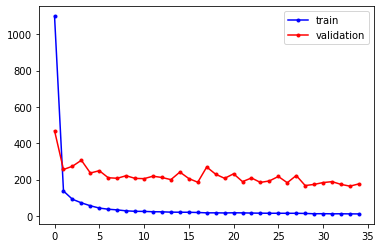

In [9]:
trainloss, valloss = history.history['loss'], history.history['val_loss']
X = [i for i in range(len(trainloss))]
plt.plot(X, trainloss, '.-b')
plt.plot(X, valloss, '.-r')
plt.legend(['train', 'validation'], loc='upper right') 
plt.show()

## Model Testing Part

Test for method 1:

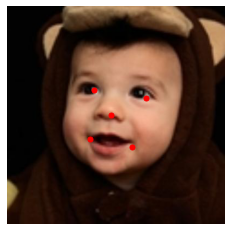

0.047167062759399414

In [23]:
# test result of method 1
address='/content/facedata/net_7876/5524_0_0.jpg'
# address='/content/drive/MyDrive/myoutput/547.jpg'
image = face_recognition.load_image_file(address)
face_locations = face_recognition.face_locations(image)
top, right, bottom, left = face_locations[0]

fraw = Image.open(address)
f1 = np.array(fraw)
rawh, raww = f1.shape[0:2]
ratioh, ratiow = 224.0 / rawh, 224.0 / raww

f1 = fraw.resize((224,224))
f1 = np.array([np.array(f1)])

t0 = time.time()
pre = model.predict(f1/255.0)
dt = time.time() - t0
f1 = f1[0]

pre[0::2] /= ratiow
pre[1::2] /= ratioh
pre = pre.astype(np.int)[0]
plt.imshow(fraw)
plt.plot(pre[0::2], pre[1::2], '.r', markersize=10)
plt.axis("off")
plt.show()
dt

In [24]:
pre, real_label
np.mean(abs(pre - real_label))

(array([160, 154, 255, 168, 190, 200, 151, 243, 230, 258]),
 array([151., 152., 243., 159., 184., 193., 149., 243., 229., 250.]))

Test for method 2: (run them all)

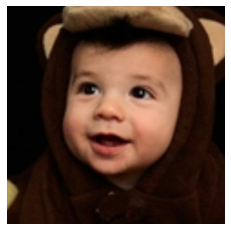

(93, 315, 316, 92)

In [11]:
# test result of method 2
address='/content/facedata/net_7876/5524_0_0.jpg'
# address='/content/drive/MyDrive/myoutput/547.jpg'
image = face_recognition.load_image_file(address)
face_locations = face_recognition.face_locations(image)

top, right, bottom, left = face_locations[0]

fraw = Image.open(address)
plt.imshow(fraw)
plt.axis("off")
plt.show()
(top, right, bottom, left)

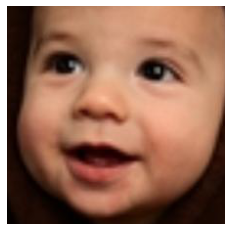

In [12]:
f1 = np.array(fraw)[top:bottom, left:right]
# f1 = np.array(fraw)[left:right, top:bottom]
rawh, raww = f1.shape[0:2]
# raww, rawh = f1.shape[0:2]
ratioh, ratiow = 224.0 / rawh, 224.0 / raww
# f1 = np.array(fraw)[left:right, top:bottom]
f1 = Image.fromarray(f1)
plt.imshow(f1)
plt.axis("off")
plt.show()

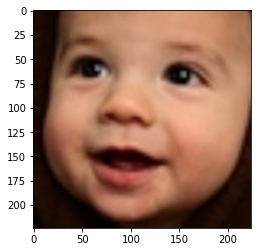

In [13]:
f1 = f1.resize((224,224))
plt.imshow(f1)
plt.show()
f1 = np.array([np.array(f1)])

In [14]:
t0 = time.time()
pre = model.predict(f1/255.0)
f1 = f1[0]
raw_pre = copy.deepcopy(pre[0])
# raw_pre[0::2] /= ratioh
# raw_pre[1::2] /= ratiow
raw_pre[0::2] /= ratiow
raw_pre[1::2] /= ratioh
dt = time.time() - t0
raw_pre = raw_pre.astype(np.int)
pre = pre.astype(np.int)[0]
pre, raw_pre, dt

(array([ 57,  62, 151,  70,  86, 108,  55, 153, 129, 161]),
 array([ 57,  62, 151,  69,  86, 107,  55, 152, 129, 160]),
 0.6125180721282959)

In [15]:
raw_pre[0::2] += left
raw_pre[1::2] += top
raw_pre

array([149, 155, 243, 162, 178, 200, 147, 245, 221, 253])

In [16]:
real_label = np.array([151.000000, 152.000000, 243.000000, 159.000000, 184.000000, 193.000000, 149.000000, 243.000000, 229.000000, 250.000000])
np.mean(abs(raw_pre - real_label))

3.6

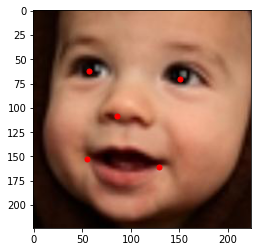

In [17]:
plt.imshow(f1)
plt.plot(pre[0::2], pre[1::2], '.r', markersize=10)
plt.show()

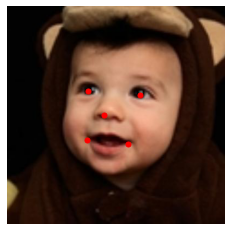

In [18]:
# test result of method 2
plt.imshow(fraw)
plt.plot(raw_pre[0::2], raw_pre[1::2], '.r', markersize=10)
plt.axis("off")
plt.show()